In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
from sklearn.model_selection import train_test_split
from tabulate import tabulate

## Prepare train and test data sets

Prepare dataframes of the file paths for the train, test and validation data sets

In [5]:
dir_path = "./data/"
file_paths = []
labels = []
folders = os.listdir(dir_path)

In [6]:
for folder in folders:
    fold_path = dir_path + folder
    for file in os.listdir(fold_path):
        file_paths.append(fold_path + "/" + file)
        labels.append(folder)

In [7]:
df = pd.DataFrame({"file_path": file_paths, "label": labels}).sample(frac=1)
df.head()

,file_path,label
4957,./data/Parasitized/C184P145ThinF_IMG_20151203_...,Parasitized
614,./data/Parasitized/C99P60ThinF_IMG_20150918_14...,Parasitized
18528,./data/Uninfected/C202ThinF_IMG_20151015_15233...,Uninfected
16995,./data/Uninfected/C174P135NThinF_IMG_20151127_...,Uninfected
22723,./data/Uninfected/C61P22N_ThinF_IMG_20150818_1...,Uninfected


In [8]:
df.describe()

,file_path,label
count,27560,27560
unique,27560,2
top,./data/Uninfected/C147P108ThinF_IMG_20151115_0...,Parasitized
freq,1,13780


In [9]:
df.reset_index(inplace=True, drop=True)
df.head(5)

,file_path,label
0,./data/Parasitized/C184P145ThinF_IMG_20151203_...,Parasitized
1,./data/Parasitized/C99P60ThinF_IMG_20150918_14...,Parasitized
2,./data/Uninfected/C202ThinF_IMG_20151015_15233...,Uninfected
3,./data/Uninfected/C174P135NThinF_IMG_20151127_...,Uninfected
4,./data/Uninfected/C61P22N_ThinF_IMG_20150818_1...,Uninfected


In [10]:
train_df, tv_df = train_test_split(df, test_size=0.2, shuffle=True)

In [11]:
valid_df, test_df = train_test_split(tv_df, test_size=0.5, shuffle=True)

In [12]:
# Get the size of the DataFrames
print(tabulate([["train_df", len(train_df)], ["test_df", len(test_df)], ["valid_df", len(valid_df)]], headers=["df", "no of samples"]))
print(f"The total number of detected file paths is: {len(df)}")

df          no of samples
--------  ---------------
train_df            22048
test_df              2756
valid_df             2756
The total number of detected file paths is: 27560


### Plot some of the images

Get a feel of the dataset haha

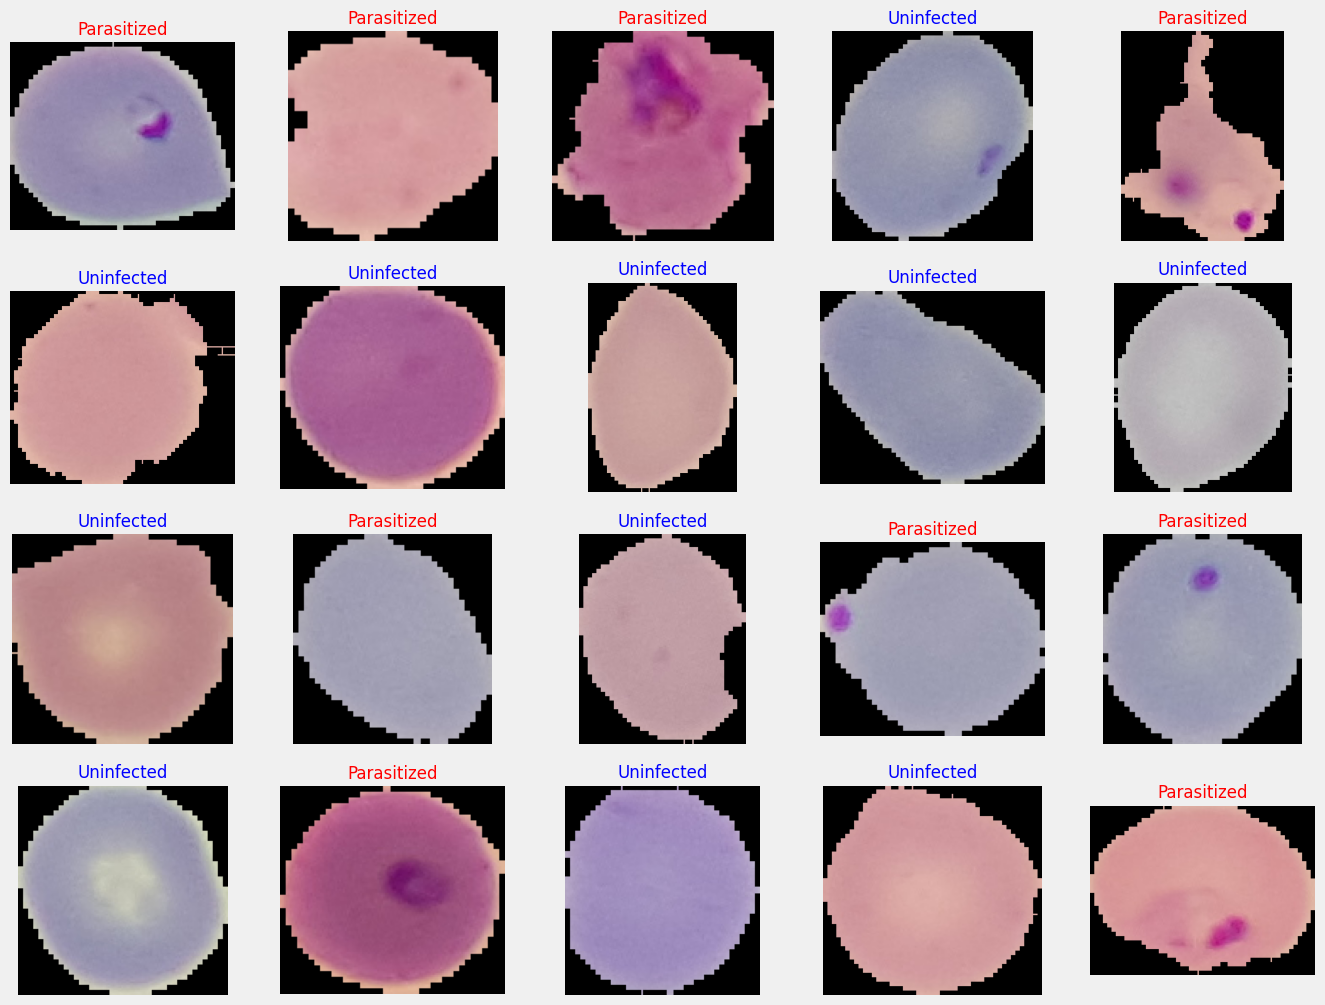

In [44]:
plt.figure(figsize=(15, 15))
for i in range(20):
    plt.subplot(5, 5, i+1)
    sample = train_df.sample().iloc[0]
    file_path = sample.file_path
    label = sample.label
    plt.imshow(image.load_img(file_path))
    color = "blue" if label=="Uninfected" else "red"
    plt.title(label, color=color, fontsize= 12)
    plt.axis('off')

## Train the model

In [14]:
# Get the number of classes - should be 2 (parasitized and uninfected)
K = df.label.nunique()
K

2

In [15]:
IMG_SIZE = (224, 224)
CHANNELS = 3
IMG_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)
TRAIN_VALID_BATCH_SIZE = 64
ts_length = len(test_df)
TEST_BATCH_SIZE = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))

In [16]:
gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

In [17]:
train_gen = gen.flow_from_dataframe(
    train_df,
    x_col="file_path",
    y_col="label",
    shuffle=True,
    target_size=IMG_SIZE,
    batch_size=TRAIN_VALID_BATCH_SIZE
)

Found 22047 validated image filenames belonging to 2 classes.


In [18]:
test_gen = gen.flow_from_dataframe(
    test_df,
    x_col="file_path",
    y_col="label",
    shuffle=False,
    target_size=IMG_SIZE,
    batch_size=TEST_BATCH_SIZE
)

Found 2756 validated image filenames belonging to 2 classes.


In [19]:
valid_gen = gen.flow_from_dataframe(
    valid_df,
    x_col="file_path",
    y_col="label",
    shuffle=True,
    target_size=IMG_SIZE,
    batch_size=TRAIN_VALID_BATCH_SIZE
)

Found 2755 validated image filenames belonging to 2 classes.


In [21]:
base_model = ResNet50(
    input_shape=IMG_SHAPE,
    weights="imagenet",
    include_top=False
)

In [22]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [23]:
base_model.trainable = False

In [24]:
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation="relu"),
    Dropout(0.2),
    Flatten(),
    Dense(K, activation="softmax")
])

In [25]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [26]:
epochs = 15
r = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    shuffle=False
)

Epoch 1/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 863s 2s/step - accuracy: 0.8532 - loss: 0.7158 - val_accuracy: 0.9089 - val_loss: 0.3892
Epoch 2/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 850s 2s/step - accuracy: 0.9213 - loss: 0.2987 - val_accuracy: 0.9416 - val_loss: 0.1972
Epoch 3/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 858s 2s/step - accuracy: 0.9390 - loss: 0.1921 - val_accuracy: 0.9426 - val_loss: 0.1698
Epoch 4/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 853s 2s/step - accuracy: 0.9455 - loss: 0.1605 - val_accuracy: 0.9485 - val_loss: 0.1677
Epoch 5/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 1072s 3s/step - accuracy: 0.9480 - loss: 0.1505 - val_accuracy: 0.9474 - val_loss: 0.1688
Epoch 6/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 1419s 4s/step - accuracy: 0.9555 - loss: 0.1315 - val_accuracy: 0.9470 - val_loss: 0.1505
Epoch 7/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 1637s 5s/step - accuracy: 0.9499 - loss: 0.1459 - val_accuracy: 0.9506 - val_loss: 0.1452
Epoch 8/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 1627s 5s/step - accuracy: 0.9523 - loss: 0.1396 - val_

## Model Evaluation

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7, 7, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │        25,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,253,000 (96.33 MB)

 Trainable params: 553,730 (2.11 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

 Optimizer params: 1,107,462 (4.22 MB)

In [32]:
tr_acc = r.history['accuracy']
tr_loss = r.history['loss']
val_acc = r.history['val_accuracy']
val_loss = r.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[best_loss_index]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[best_train_acc_index]
epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

#### Plot train history

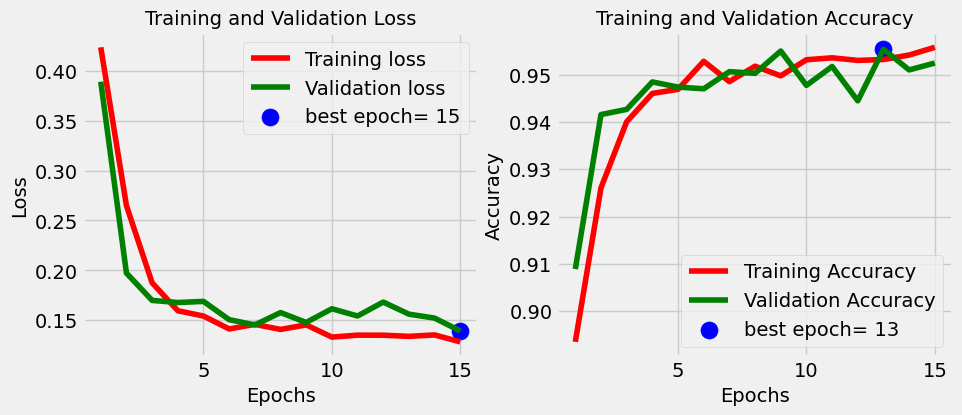

In [34]:
plt.figure(figsize= (10, 4))
plt.style.use('fivethirtyeight')

# Plot training and validation losses 
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend();

In [35]:
test_length = len(test_df)
steps = test_length // TEST_BATCH_SIZE
test_score = model.evaluate(test_gen, steps=steps)

52/52 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - accuracy: 0.9519 - loss: 0.1394


In [36]:
print(f"Test loss: {test_score[0]: .06f}")
print(f"Test accuracy: {round(test_score[1]*100)}%") 

Test loss:  0.135653
Test accuracy: 95%


### Generate confusion matrix and classification report

In [37]:
Yhat = np.argmax(model.predict(test_gen), axis=1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 216s 4s/step


In [38]:
Ytrue = test_gen.classes
labels = list(test_gen.class_indices.keys())

#### Confusion matrix

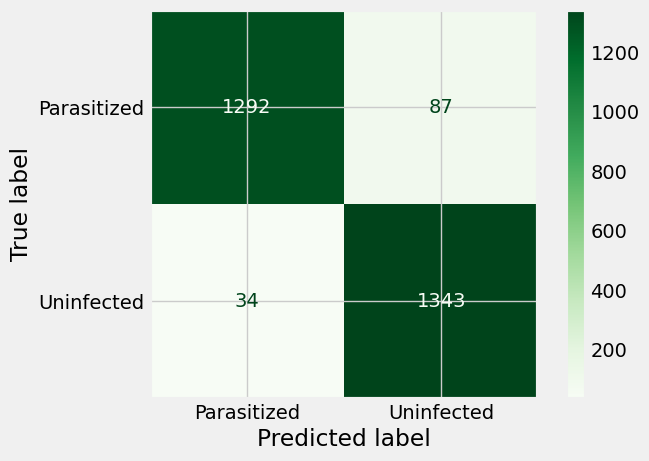

In [39]:
cm = confusion_matrix(y_true=np.array(Ytrue).flatten(), y_pred=Yhat.flatten())
display = ConfusionMatrixDisplay(cm, display_labels=test_gen.class_indices)
display.plot(cmap="Greens");

#### Classification report

In [40]:
print(classification_report(y_true=Ytrue, y_pred=Yhat, target_names=labels))

              precision    recall  f1-score   support

 Parasitized       0.97      0.94      0.96      1379
  Uninfected       0.94      0.98      0.96      1377

    accuracy                           0.96      2756
   macro avg       0.96      0.96      0.96      2756
weighted avg       0.96      0.96      0.96      2756



## Save the model

In [41]:
model.save("malaria_diagnosis_Resnet50.keras")